# Stable Diffusion

<img src='https://miro.medium.com/v2/resize:fit:2000/format:webp/1*pFNOzxb0_7WkcAyK5NhMxA.png' width='600'>

Diffusion models:
- use fuzzy noise to encode an image.
- use a noise predictor along with a reverse diffusion process to put the image back together.

Stable Diffusion (a Diffusion models):
- don't use the pixel space of the image.
- uses a simplified latent space.
- uses variational autoencoder (VAE) files in the decoder to capture intricate details such as eyes.

`Note:` 
- The effectiveness of the smaller latent space is based on the idea that natural images follow patterns rather than randomness.
-  **Variational Autoencoders (VAEs)**: VAEs are a type of generative model that learns to encode data into a compressed latent space and then decode it back into data. They are particularly useful for generating variations of the input data.

# Architecture of Stable Diffusion

The main architectural components consist of:
1. **VAE**:
- consists of an encoder and decoder.
- Encoder compresses a 512x512 pixel image into a smaller 64x64 model in latent space.
- Decoder restores the model from latent space into a full-size 512x512 pixel image.
2. **Forward Diffusion**:
- Adds Gaussian noise to an image progressively until only random noise remains.
- Used during training but not for other tasks, except image-to-image conversion.
3. **Reverse Diffusion**:
- Iteratively undoes forward diffusion.
- Trained on billions of images using prompts to create unique images.
4. **Noise Predictor (U-Net)**:
- Utilizes a U-Net model for denoising images.
- U-Net models are convolutional neural networks, with Stable Diffusion using the Residual Neural Network (ResNet) model.
5. **Text Conditioning**:
- Text prompts are a common form of conditioning.
- A CLIP tokenizer analyzes each word in a textual prompt and embeds the data into a 768-value vector.
- Up to 75 tokens can be used in a prompt.
- Text prompts are fed from the text encoder to the U-Net noise predictor using a text transformer.
- Setting the seed to a random number generator generates different images in the latent space.

# Libs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
# import tqdm
from tqdm import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
%matplotlib inline
from torchvision.utils import make_grid
from einops import rearrange
import math

# Dataset

The small dataset - [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset

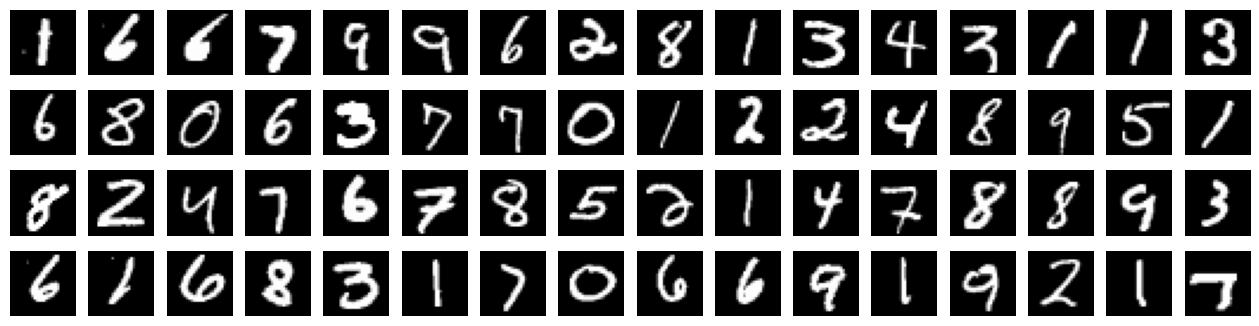

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Extract a batch of unique images
unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.numpy()

# Display a grid of unique images
fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):
    for j in range(16):
        index = i * 16 + j  # Calculate the index in the batch
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray')
        axes[i, j].axis('off')

plt.show()

# Basic forward diffusion

$$x(t+\Delta t)=x(t)+\sigma(t)\sqrt{\Delta t}\cdot r$$

- $\sigma(t)>0$: the **noise strength** (increase with time).
- $\Delta t$: the **step size**.
- $r\sim N(0,1)$: a **standard normal random variable**.

In [3]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)
    
    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):        
        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + noise_strength * random_normal * np.sqrt(dt)

    return x, t

Example noise strength function: always equal to 1.

In [4]:
def noise_strength_constant(t):
    """
    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

Illustrate the forward diffusion process, slowly introducing noise to the starting sample. This leads to the creation of various samples as the diffusion process progresses.

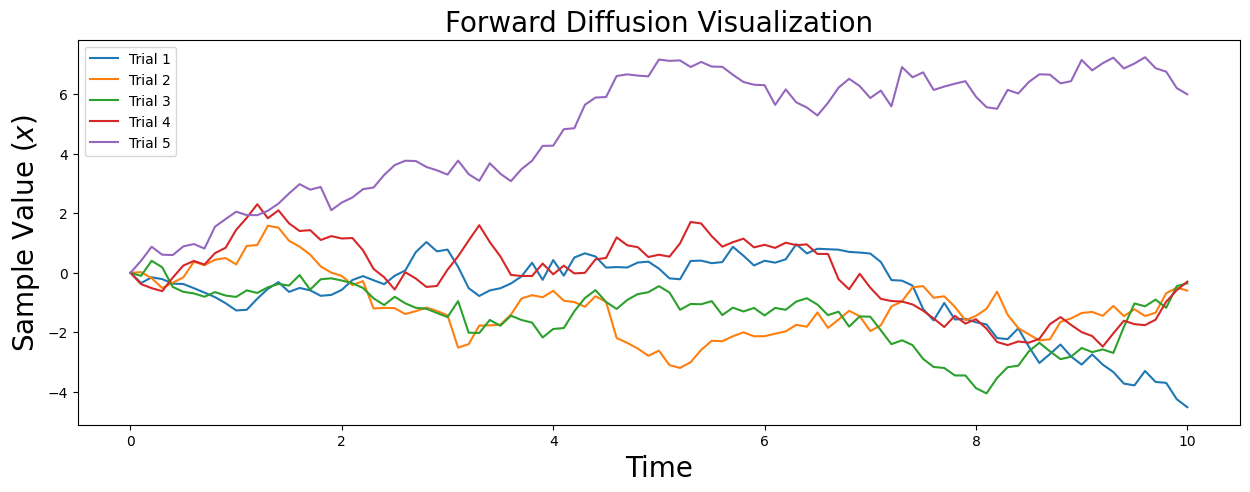

In [5]:
nsteps = 100    # Number of diffusion steps
t0 = 0          # Initial time
dt = 0.1        # Time step size
noise_strength_fn = noise_strength_constant # Noise strength function
x0 = 0          # Initial sample value
num_tries = 5   # Number of tries for visualization

plt.figure(figsize=(15, 5))

for i in range(num_tries):
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt) # Simulate forward diffusion
    plt.plot(t, x, label=f'Trial {i+1}')

plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)
plt.title('Forward Diffusion Visualization', fontsize=20)
plt.legend()
plt.show()

# Basic reverse diffusion

$$x(t+\Delta t)=x(t)+\sigma^2(T-t)\cdot s(x,T-t)\Delta t+\sigma(T-t)\sqrt{\Delta t}\cdot r$$
- $T$: final time
- $s(x,t)=\frac{d}{dx}\log p(x,t)$: **score function** allows to:
    - reverse the forward diffusion
    - convert noise back into initial state.

In [6]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)
    
    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):
        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    return x, t

If the starting point is always at $x_0=0$ and the noise strength is constant, then:
$$s(x,t)=-\frac{x-x_0}{\sigma^2t}=-\frac{x}{\sigma^2t}$$

In [7]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """
    score = - (x - x0) / ((noise_strength**2) * t)
    return score

check whether everse diffusion function is working correctly

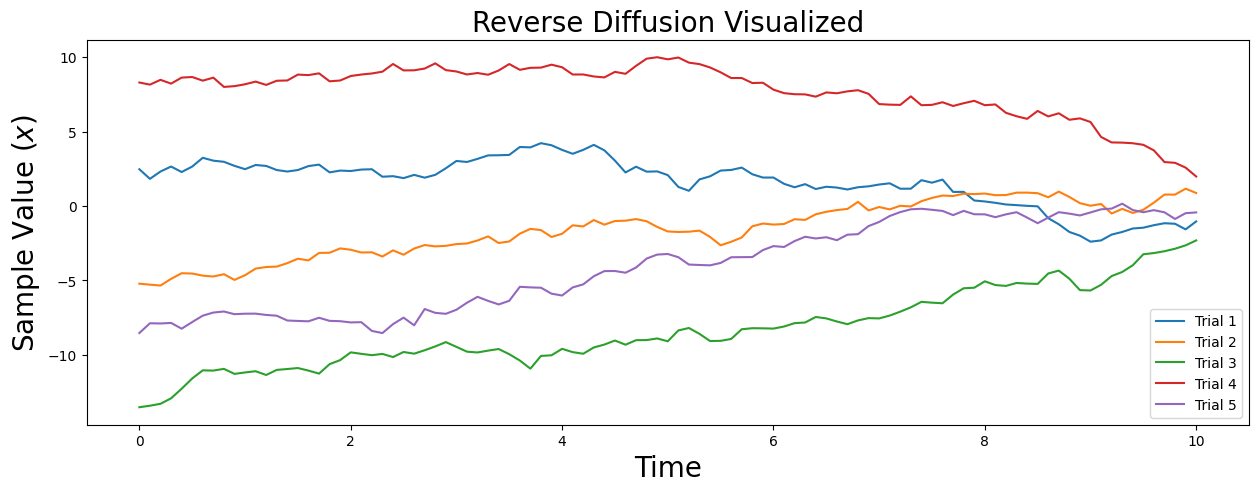

In [8]:
nsteps = 100    # Number of reverse diffusion steps
t0 = 0          # Initial time for reverse diffusion
dt = 0.1        # Time step size for reverse diffusion
noise_strength_fn = noise_strength_constant # Function defining constant noise strength for reverse diffusion
score_fn = score_simple # Example score function for reverse diffusion
x0 = 0          # Initial sample value for reverse diffusion
T = 11          # Final time for reverse diffusion
num_tries = 5   # Number of tries for visualization

plt.figure(figsize=(15, 5))
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')

plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)
plt.title('Reverse Diffusion Visualized', fontsize=20)
plt.legend()
plt.show()

This visualization shows that after the forward diffusion process creates a sample from the complex data distribution, the reverse diffusion process maps it back to the simple distribution using a series of inverse transformations.

# Learning Score Function

The process of learning the score function involves transforming random noise into meaningful patterns. To achieve this, a neural network is used to approximate the score function.

One approach involves training a neural network to **‘denoise’** samples using the **denoising objective**:
$$J:=\mathbb{E}_{t\in(0,T),x_0\sim p_0(x_0)}\left[||s(x_{\text{noised}},t)\sigma^2(t)+(x_{\text{noised}}-x_0)||^2_2\right]$$

- $\mathbb{E}$: the expectation.
- $t$: the time parameter.
- $x_0$: is a sample from the $p_0(x_0)$.
- $p_0(x_0)$: **target distribution** (e.g., images of cars and cats)
- $x_{\text{noised}}$: the sample from **the target distribution** $x_0$​ after a single forward diffusion step.
- $x_{\text{noised}} - x_0$: is essentially a **normally-distributed** random variable.

other way to write denoising objective equation:
$$J:=\mathbb{E}_{t\in(0,T),x_0\sim p_0(x_0),\epsilon\sim\mathcal{N}(0,I)}\left[||s(x_0+\sigma(t)\epsilon,t)\sigma(t)+\epsilon||^2_2\right]$$
- $\epsilon$: is a **normally-distributed** random variable.

**Aim**: predict the amount of noise added to each part of our sample effectively at every time $t$ in the diffusion process and for every $x_0$​ in our original distribution.

# Time Embedding for Neural Network

Since the score function depends on time, a time embedding is used to ensure the neural network can accurately respond to time variations.

The current time is represented through multiple sinusoidal features, enabling more effective learning of the time-dependent score function **s(x,t)**.

In [ ]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()
        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

The `GaussianFourierProjection` module is for generating Gaussian random features, which will be used to represent time steps into the neural network.
- generates random frequencies that remain fixed throughout the optimization process.
- computes sine and cosine projections of an input tensor `x` by multiplying `x` with the pre-defined random frequencies.
- concatenate projections to form a feature representation of the input, effectively capturing temporal patterns.

In [10]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

The output of `Dense` is reshaped into a 4D tensor feature map by adding two singleton dimensions at the end ([..., None, None]).

# The U-Net Architecture with Concatenation

[U-Net](https://www.geeksforgeeks.org/u-net-architecture-explained/) combines a CNN-like structure with downscaling/upscaling operations. This combination helps the network focus on image features at different spatial scales.

In [11]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Additional encoding layers (copied from the original code)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        # Additional encoding path layers (copied from the original code)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

The model leverages a U-Net architecture to understand how images change over time. It takes an initial image and learns patterns from its transformations across different time steps. The U-Net consists of:
- an encoding path, where image data is downsampled through successive convolutional layers (h1 to h4).
- a decoding path, where spatial information is recovered using transpose convolutions. 
- During decoding, earlier features are added back to aid upsampling, ultimately producing the final output.
- A normalization step ensures that the generated image is properly scaled.
- The shape of tensors evolves throughout the network, influenced by factors like filter sizes, strides, and padding, which enable the model to capture and reconstruct visual details effectively.

# The U-Net Architecture with Addition

In [12]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

The UNet_res model is a variant of the standard UNet model. The key difference lies in how skip connections are implemented:
- In the original UNet model, skip connections concatenate tensors from the encoding path with tensors in the decoding path.
- In the UNet_res model, skip connections involve directly adding tensors from the encoding path to the corresponding tensors in the decoding path. This variation in skip connection strategies can influence the information flow and interactions between different resolution levels, potentially affecting the model’s capacity to capture features and dependencies in the data.

# Forward Diffusion Process with Exponential Noise

The specific forward diffusion process:
$$dx=\sigma^tdw$$

The formula represents a dynamic system where the variable $x$ changes over time $(t)$ with the introduction of noise $(dw)$. The noise level is determined by the parameter $\sigma$, and it increases exponentially as time progresses.

Given this process and an initial value $x(0)$, we can find an analytical solution for $x(t)$:
$$p(x(t)|x(0))=\mathcal{N}(x(0),\sigma(t)^2)$$
- $\sigma(t)$: the marginal standard deviation.
- $\sigma(t)$ represents the variability of the distribution of $x(t)$ given the initial value $x(0)$.

For our specific case, the marginal standard deviation is calculated as:
$$\sigma^2(t)=\int_0^t(\sigma^\mathcal{T})^2d\mathcal{T}=\frac{\sigma^{2t}-1}{2\log\sigma}$$
- This formula provides a detailed understanding of how the noise level $(\sigma)$ evolves over time, influencing the variability of the system.

In [13]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)
    
    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [14]:
def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)

In [15]:
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Loss Function

This loss function involves:
- picking a random time
- getting the noise level
- adding this noise to our data
- checking how off model’s prediction is from reality.

The aim is to reduce this error during training.

In [16]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)
    
    # Generate normally distributed noise
    z = torch.randn_like(x)
    
    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]
    
    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)
    
    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    
    return loss

# Sampler

Stable Diffusion creates an image by:
- starting with a totally random one.
- The noise predictor then guesses how noisy the image is.
- this guessed noise is removed from the image.
- This whole cycle repeats several times, resulting in a clean image.

This cleaning-up process is called `“sampling”` because Stable Diffusion produces a fresh image sample at each step.

Stable Diffusion has various options for creating image samples, and one method we’ll use is the `Euler–Maruyama method` (Euler method).

`Euler method`:
- combines a score-based model, a function for noise standard deviation, and a diffusion coefficient.
- iteratively applies the method over a number of steps.
- returning the final set of generated samples.

In [17]:
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(1, 28, 28),
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    
    # Do not include any noise in the last sampling step.
    return mean_x

# Training U-Net Concatenation Architecture

In [18]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 18 #50
batch_size = 2048
lr = 5e-4

# Load the MNIST dataset and create a data loader
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)

In [18]:
# Progress bar for epochs
# tqdm_epoch = trange(n_epochs)
tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), './models/ckpt.pth')

  0%|          | 0/18 [00:00<?, ?it/s]C:\Users\dangc\AppData\Local\Temp\ipykernel_1740\2731177002.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Average Loss: 73.863601: 100%|██████████| 18/18 [42:27<00:00, 141.53s/it]


Let’s visualize the results. The current visualization is simply based on random inputs.

C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2731177002.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2365451528.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:19<00:00, 26.11it/s]


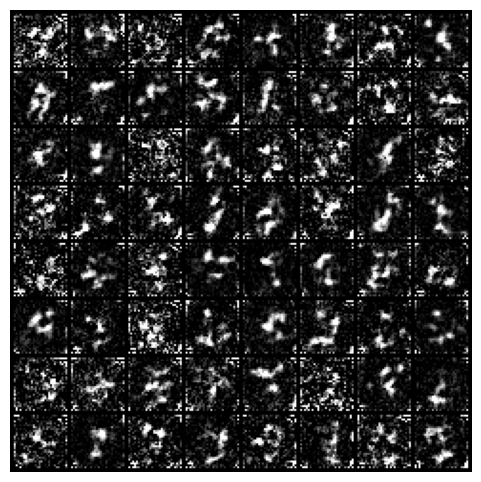

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained model checkpoint
ckpt = torch.load('models/ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
num_steps = 500

sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

`Note:` The current results are not satisfactory.

# Training U-Net Addition Architecture

In [20]:
# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 20 #75
batch_size = 1024
lr = 1e-3

# Load the MNIST dataset for training.
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

In [23]:
# Training loop over epochs.
# tqdm_epoch = trange(n_epochs)
tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    
    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    
    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), './models/ckpt_res.pth')

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\dangc\AppData\Local\Temp\ipykernel_17420\2731177002.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Average Loss: 944.729995:   5%|▌         | 1/20 [01:31<28:57, 91.45s/it]

0 Average Loss: 944.729995 lr 9.8e-04


Average Loss: 286.764148:  10%|█         | 2/20 [03:32<32:42, 109.02s/it]

1 Average Loss: 286.764148 lr 9.6e-04


Average Loss: 196.207846:  15%|█▌        | 3/20 [06:25<39:11, 138.32s/it]

2 Average Loss: 196.207846 lr 9.4e-04


Average Loss: 149.327210:  20%|██        | 4/20 [09:18<40:30, 151.93s/it]

3 Average Loss: 149.327210 lr 9.2e-04


Average Loss: 121.745311:  25%|██▌       | 5/20 [12:18<40:30, 162.02s/it]

4 Average Loss: 121.745311 lr 9.0e-04


Average Loss: 103.059116:  30%|███       | 6/20 [15:20<39:21, 168.65s/it]

5 Average Loss: 103.059116 lr 8.9e-04


Average Loss: 90.764849:  35%|███▌      | 7/20 [18:18<37:15, 171.97s/it] 

6 Average Loss: 90.764849 lr 8.7e-04


Average Loss: 81.550565:  40%|████      | 8/20 [21:16<34:45, 173.79s/it]

7 Average Loss: 81.550565 lr 8.5e-04


Average Loss: 74.563355:  45%|████▌     | 9/20 [24:15<32:08, 175.27s/it]

8 Average Loss: 74.563355 lr 8.3e-04


Average Loss: 68.926033:  50%|█████     | 10/20 [27:12<29:18, 175.84s/it]

9 Average Loss: 68.926033 lr 8.2e-04


Average Loss: 64.416105:  55%|█████▌    | 11/20 [30:05<26:15, 175.02s/it]

10 Average Loss: 64.416105 lr 8.0e-04


Average Loss: 60.827353:  60%|██████    | 12/20 [33:01<23:22, 175.35s/it]

11 Average Loss: 60.827353 lr 7.8e-04


Average Loss: 57.687487:  65%|██████▌   | 13/20 [36:26<21:29, 184.22s/it]

12 Average Loss: 57.687487 lr 7.7e-04


Average Loss: 54.870186:  70%|███████   | 14/20 [38:41<16:56, 169.36s/it]

13 Average Loss: 54.870186 lr 7.5e-04


Average Loss: 52.916694:  75%|███████▌  | 15/20 [41:42<14:25, 173.07s/it]

14 Average Loss: 52.916694 lr 7.4e-04


Average Loss: 50.802304:  80%|████████  | 16/20 [44:09<10:59, 164.98s/it]

15 Average Loss: 50.802304 lr 7.2e-04


Average Loss: 48.875460:  85%|████████▌ | 17/20 [45:32<07:01, 140.52s/it]

16 Average Loss: 48.875460 lr 7.1e-04


Average Loss: 47.215732:  90%|█████████ | 18/20 [46:56<04:06, 123.33s/it]

17 Average Loss: 47.215732 lr 7.0e-04


Average Loss: 45.876946:  95%|█████████▌| 19/20 [48:34<01:55, 115.98s/it]

18 Average Loss: 45.876946 lr 6.8e-04


Average Loss: 44.493993: 100%|██████████| 20/20 [50:23<00:00, 151.19s/it]

19 Average Loss: 44.493993 lr 6.7e-04


Let’s visualize the results

C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2731177002.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2365451528.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:15<00:00, 31.25it/s]


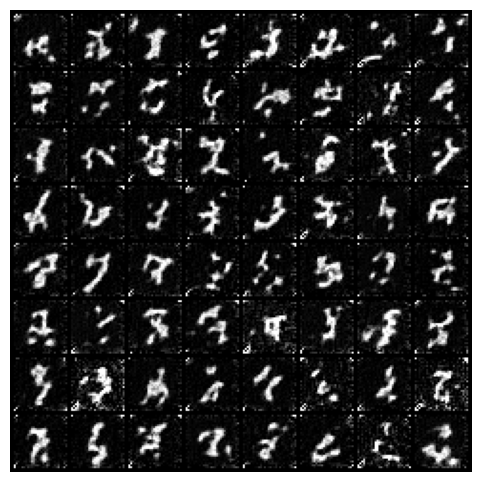

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained model checkpoint
ckpt = torch.load('models/ckpt_res.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
num_steps = 500
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

`Note:` has better performance compared to the concatenation architecture. The loss consistently decreases during training using this architecture.

Up until now, 2 above architectures have generated random image samples. However, the goal is to enable stable diffusion model to hand-draw a specified number when provided as input.

# Building Attention Layers

There are 3 main parts:
- **Cross Attention**: Handles self/cross attention for sequences.
- **Transformer Block**: Combines attention with a neural network for processing.
- **Spatial Transformer**: Transforms the spatial tensor in a U-net to a sequential form and vice versa.

In QKV attention, queries, keys, and values vectors connect words or images on one side of a translation task to the other side.

These vectors (q, k, v) are linearly related to the encoder’s hidden state vectors (e) and the decoder’s hidden state vectors (h):
- $q_i=W_qh_i$
- $k_j=W_ke_j$
- $v_j=W_ve_j$

To decide what to ‘pay attention’ to, calculate the inner product (similarity) of each key (k) and query (q).

To ensure the values are reasonable, normalize them by the length of the query vectors ($q_i$).

The final attention distribution is obtained by applying softmax to these values:
$$a_{ij}=\text{SoftMax}\left(\frac{k_jq_i}{\sqrt{\text{len}(q_i)}}\right)$$

s.t. $\sum_ja_{ij}=1$

This attention distribution helps pick out a relevant combination of features. e.g. when translating the phrase **“This is cool”** from English to French, the correct answer (**“c’est cool”**) involves paying attention to both words simultaneously, rather than translating each word separately. Mathematically, we use the attention distribution to weight the values ($v_j$):
$$c_i:=\sum_ja{ij}v_j$$

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        
        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)
    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                   If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

The `CrossAttention` takes input tokens and, optionally, context information.
- If used for self-attention, it focuses on relationships within the input tokens.
- In the case of cross-attention, it considers the interaction between input tokens and context information.
- The module employs linear projections for query, key, and value transformations.
- calculates score matrices
- applies softmax for attention weights
- computes context vectors by combining the weighted values based on attention weights.

This mechanism allows the network to selectively focus on different parts of the input or context, aiding in capturing relevant information during the learning process.

In [ ]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )
    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

The `TransformerBlock`
- incorporates self-attention, cross-attention, and a feed-forward neural network.
- takes input tensors with shape [batch, sequence_len, hidden_dim] and, optionally, a context tensor with shape [batch, context_seq_len, context_dim].
- The self-attention and cross-attention modules are followed by layer normalization and a residual connection. 
- Additionally, the block includes a two-layer MLP with a GELU nonlinearity for further non-linear transformations.

In [24]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()
        
        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

# U-Net Architecture with Spatial Transformer

In [25]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

# Updating U-Net Loss with Denoising Condition

Update the loss function by incorporating the y information during training.

This updated loss function calculates the loss for training generative models with added conditions:
- sampling time
- generating noise
- perturbing the input data
- computing the loss based on the model’s score and perturbation.

In [26]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

# Training U-Net Architecture With Attention Layers

The advantage: once trained, we can provide a specific number for our stable diffusion model to draw.

In [29]:
# Specify whether to continue training or initialize a new model
continue_training = False # Either True or False

if not continue_training:
    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

# Set training hyperparameters
n_epochs =   20 #100   #{'type':'integer'}
batch_size =  1024 #{'type':'integer'}
lr = 10e-4         #{'type':'number'}

# Load the MNIST dataset and create a data loader
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

In [30]:
# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)

        # Compute the loss using the conditional score-based model
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), './models/ckpt_transformer.pth')

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2731177002.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Average Loss: 1017.334714:   5%|▌         | 1/20 [02:21<44:42, 141.19s/it]

0 Average Loss: 1017.334714 lr 9.8e-04


Average Loss: 295.498205:  10%|█         | 2/20 [05:00<45:36, 152.04s/it] 

1 Average Loss: 295.498205 lr 9.6e-04


Average Loss: 195.519414:  15%|█▌        | 3/20 [07:39<43:59, 155.28s/it]

2 Average Loss: 195.519414 lr 9.4e-04


Average Loss: 147.231772:  20%|██        | 4/20 [10:14<41:22, 155.15s/it]

3 Average Loss: 147.231772 lr 9.2e-04


Average Loss: 118.268672:  25%|██▌       | 5/20 [12:58<39:34, 158.28s/it]

4 Average Loss: 118.268672 lr 9.0e-04


Average Loss: 100.753664:  30%|███       | 6/20 [15:40<37:10, 159.32s/it]

5 Average Loss: 100.753664 lr 8.9e-04


Average Loss: 88.641982:  35%|███▌      | 7/20 [18:22<34:43, 160.27s/it] 

6 Average Loss: 88.641982 lr 8.7e-04


Average Loss: 79.948251:  40%|████      | 8/20 [21:03<32:06, 160.56s/it]

7 Average Loss: 79.948251 lr 8.5e-04


Average Loss: 72.945015:  45%|████▌     | 9/20 [23:48<29:40, 161.91s/it]

8 Average Loss: 72.945015 lr 8.3e-04


Average Loss: 67.922151:  50%|█████     | 10/20 [26:29<26:56, 161.66s/it]

9 Average Loss: 67.922151 lr 8.2e-04


Average Loss: 63.193529:  55%|█████▌    | 11/20 [29:06<24:02, 160.32s/it]

10 Average Loss: 63.193529 lr 8.0e-04


Average Loss: 60.126211:  60%|██████    | 12/20 [31:49<21:28, 161.02s/it]

11 Average Loss: 60.126211 lr 7.8e-04


Average Loss: 56.839669:  65%|██████▌   | 13/20 [34:29<18:45, 160.82s/it]

12 Average Loss: 56.839669 lr 7.7e-04


Average Loss: 54.340119:  70%|███████   | 14/20 [37:11<16:06, 161.01s/it]

13 Average Loss: 54.340119 lr 7.5e-04


Average Loss: 52.057525:  75%|███████▌  | 15/20 [39:51<13:23, 160.69s/it]

14 Average Loss: 52.057525 lr 7.4e-04


Average Loss: 50.537041:  80%|████████  | 16/20 [42:31<10:42, 160.74s/it]

15 Average Loss: 50.537041 lr 7.2e-04


Average Loss: 48.599028:  85%|████████▌ | 17/20 [45:08<07:58, 159.55s/it]

16 Average Loss: 48.599028 lr 7.1e-04


Average Loss: 46.639125:  90%|█████████ | 18/20 [47:44<05:16, 158.41s/it]

17 Average Loss: 46.639125 lr 7.0e-04


Average Loss: 45.339785:  95%|█████████▌| 19/20 [50:12<02:35, 155.29s/it]

18 Average Loss: 45.339785 lr 6.8e-04


Average Loss: 44.037585: 100%|██████████| 20/20 [52:44<00:00, 158.20s/it]

19 Average Loss: 44.037585 lr 6.7e-04


# Generating Images

Now, with the addition of conditional generation through attention layers, we can instruct the stable diffusion model to draw any digit.

C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2731177002.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\dangc\AppData\Local\Temp\ipykernel_9964\2365451528.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 250/250 [00:16<00:00, 15.09it/s]


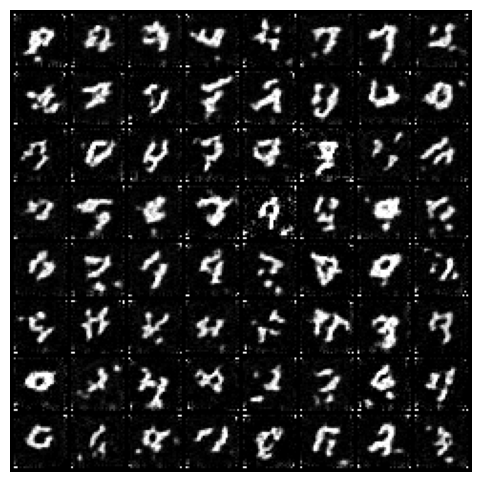

In [ ]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = torch.load('models/ckpt_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)

########### Specify the digit for which to generate samples
###########
digit = 9 #@param {'type':'integer'}
###########
###########

# Set the batch size for generating samples
sample_batch_size = 64 #@param {'type':'integer'}
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250 #@param {'type':'integer'}
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)

# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# Reference

[Coding Stable Diffusion from Scratch](https://levelup.gitconnected.com/building-stable-diffusion-from-scratch-using-python-f3ebc8c42da3)